✅ Loaded 196 rows


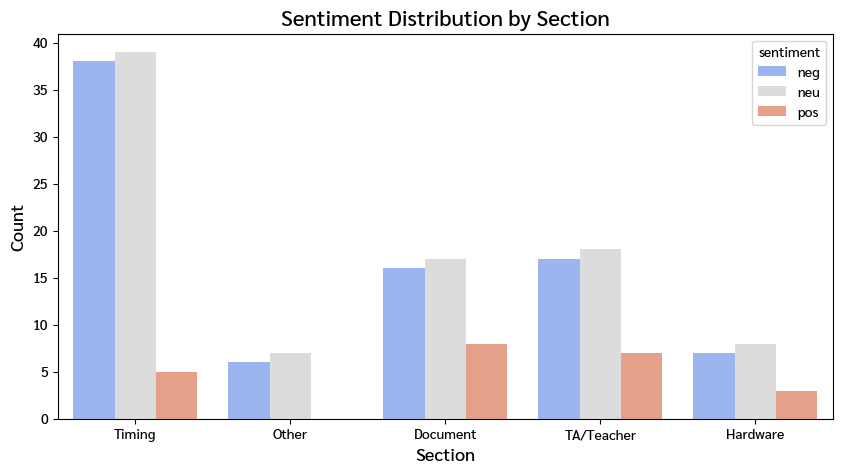

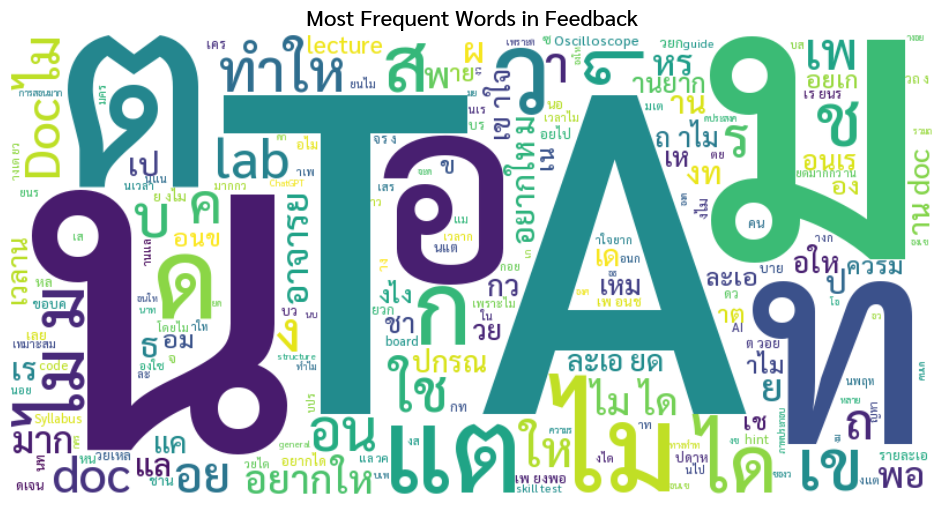

✅ Exported sentiment data to ../data/processed/feedback_sentiment.csv

📊 Summary of average sentiment:
      section  sentiment_score
0    Document        -0.195122
1    Hardware        -0.222222
3  TA/Teacher        -0.238095
4      Timing        -0.402439
2       Other        -0.461538


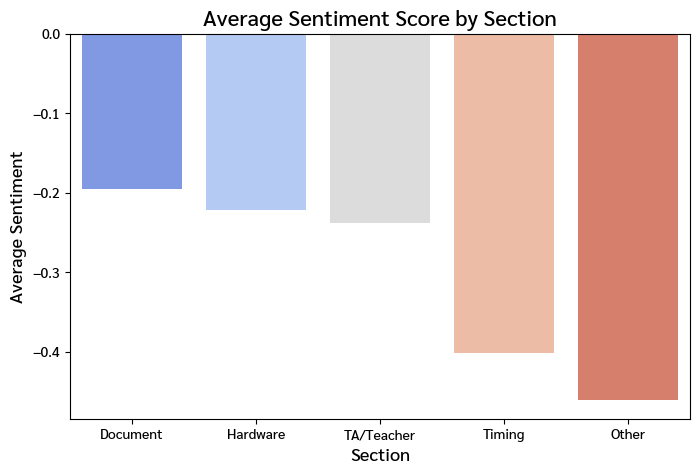

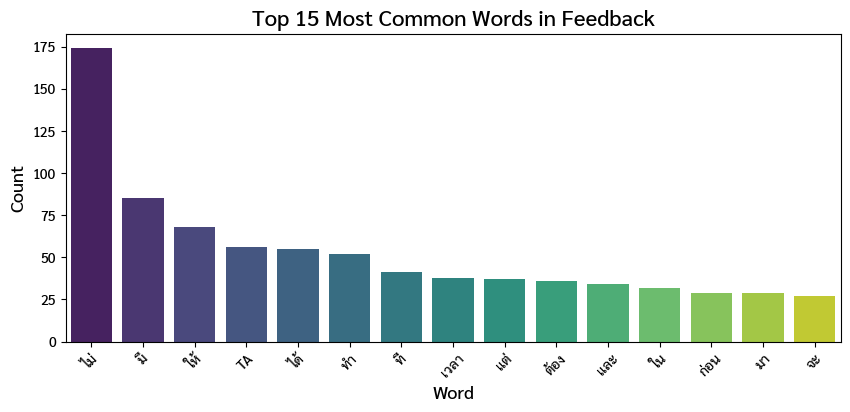


📌 Key Insights:
- ⏱️ Timing เป็นประเด็นที่ถูกพูดถึงบ่อยที่สุด และมักมี sentiment ลบ
- 📄 Document section มี sentiment ต่ำสุด (เช่น Doc ไม่ละเอียด / เข้าใจยาก)
- 🙋‍♂️ TA/Teacher section มีทั้งคำชมและข้อบ่นเรื่องจำนวนน้อย
- 🔌 Hardware ส่วนใหญ่เป็นกลางถึงบวก แต่บ่นเรื่องอุปกรณ์ไม่พอในบางคาบ


In [1]:
# =========================
# STEP 1: Import libraries
# =========================
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine, text
from dotenv import load_dotenv
from wordcloud import WordCloud
from collections import Counter
from pythainlp.tokenize import word_tokenize
import matplotlib.font_manager as fm

# =========================
# STEP 2: Font setup (TH Sarabun New)
# =========================
font_path = os.path.join(os.getcwd(), "THSarabunNew.ttf")
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = fm.FontProperties(fname=font_path).get_name()

# =========================
# STEP 3: Load data from PostgreSQL
# =========================
load_dotenv()

DB_USER = os.getenv("POSTGRES_USER", "postgres")
DB_PASS = os.getenv("POSTGRES_PASSWORD", "postgres123")
DB_NAME = os.getenv("POSTGRES_DB", "feedbackdb")
DB_PORT = os.getenv("POSTGRES_PORT", "5433")
DB_HOST = os.getenv("POSTGRES_HOST", "localhost")

engine = create_engine(f"postgresql+psycopg2://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}")

df = pd.read_sql_query("SELECT section, category, comment FROM feedback;", engine)
print(f"✅ Loaded {len(df)} rows")

# =========================
# STEP 4: Sentiment Analysis (Rule-based)
# =========================
positive_keywords = ["เข้าใจ", "เยี่ยม", "โอเค", "ชอบ", "สุดยอด", "ขอบคุณ", "เยอะ", "เร็ว", "ตรงเวลา", "คุ้มค่า"]
negative_keywords = ["ไม่เข้าใจ", "แย่", "ไม่ดี", "ไม่มี", "ลำบาก", "หงุดหงิด", "น้อย", "ช้า", "เสียเวลา", "ยาก", "งง"]

def simple_sentiment(text):
    if not isinstance(text, str):
        return "neu"
    pos = sum(word in text for word in positive_keywords)
    neg = sum(word in text for word in negative_keywords)
    if pos > neg:
        return "pos"
    elif neg > pos:
        return "neg"
    return "neu"

df["sentiment"] = df["comment"].apply(simple_sentiment)
df["sentiment_score"] = df["sentiment"].map({"pos": 1, "neu": 0, "neg": -1})

# =========================
# STEP 5: Visualization 1 – Sentiment Distribution by Section
# =========================
plt.figure(figsize=(10,5))
sns.countplot(data=df, x="section", hue="sentiment", palette="coolwarm")
plt.title("Sentiment Distribution by Section", fontsize=16)
plt.xlabel("Section", fontsize=13)
plt.ylabel("Count", fontsize=13)
plt.show()

# =========================
# STEP 6: Word Cloud (Thai font)
# =========================
text = " ".join(df["comment"].dropna())
wc = WordCloud(
    font_path=font_path,
    width=800,
    height=400,
    background_color="white"
).generate(text)

plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words in Feedback", fontsize=16)
plt.show()

# =========================
# STEP 7: Export to CSV (for Dashboard)
# =========================
os.makedirs("../data/processed", exist_ok=True)
out_path = "../data/processed/feedback_sentiment.csv"
df.to_csv(out_path, index=False, encoding="utf-8-sig")
print(f"✅ Exported sentiment data to {out_path}")

# =========================
# STEP 8: Summary – Average Sentiment per Section
# =========================
summary = (
    df.groupby("section")["sentiment_score"]
    .mean()
    .reset_index()
    .sort_values("sentiment_score", ascending=False)
)
print("\n📊 Summary of average sentiment:")
print(summary)

plt.figure(figsize=(8,5))
sns.barplot(data=summary, x="section", y="sentiment_score", hue="section", palette="coolwarm", legend=False)
plt.title("Average Sentiment Score by Section", fontsize=16)
plt.xlabel("Section", fontsize=13)
plt.ylabel("Average Sentiment", fontsize=13)
plt.show()

# =========================
# STEP 9: Keyword Frequency
# =========================
all_words = []
for text in df["comment"].dropna():
    all_words.extend(word_tokenize(text, keep_whitespace=False))

common_words = Counter(all_words).most_common(15)
common_df = pd.DataFrame(common_words, columns=["Word", "Count"])

plt.figure(figsize=(10,4))
sns.barplot(data=common_df, x="Word", y="Count", hue="Word", palette="viridis", legend=False)
plt.title("Top 15 Most Common Words in Feedback", fontsize=16)
plt.xticks(rotation=45, fontproperties=fm.FontProperties(fname=font_path))
plt.xlabel("Word", fontsize=13)
plt.ylabel("Count", fontsize=13)
plt.show()

# =========================
# STEP 10: Insight Summary
# =========================
print("\n📌 Key Insights:")
print("- ⏱️ Timing เป็นประเด็นที่ถูกพูดถึงบ่อยที่สุด และมักมี sentiment ลบ")
print("- 📄 Document section มี sentiment ต่ำสุด (เช่น Doc ไม่ละเอียด / เข้าใจยาก)")
print("- 🙋‍♂️ TA/Teacher section มีทั้งคำชมและข้อบ่นเรื่องจำนวนน้อย")
print("- 🔌 Hardware ส่วนใหญ่เป็นกลางถึงบวก แต่บ่นเรื่องอุปกรณ์ไม่พอในบางคาบ")
